# Lab 8: Linear Regression

In [12]:
# Import Libraries

import numpy as np
import pandas as pd

import sqlite3

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Loading data

# path to our sql database file
db_file = './our_sql_database.db'

# Establish a connection to the SQLite database
conn = sqlite3.connect(db_file)

# Create a cursor object
cursor = conn.cursor()

# Execute an SQL SELECT query to fetch column 'IQ' from the table iq_income
cursor.execute("SELECT IQ FROM iq_income")  

# Fetch data from the query results
iq_values = cursor.fetchall()  # You can also use fetchone() or fetchmany() depending on your needs

# Convert into numpy array and reshape to go from shape (1000,1) to (1000)
iq_values = np.asarray(iq_values)[:,0]

# Repeating for the other column 'Income'
cursor.execute("SELECT Income FROM iq_income")  
income_values = cursor.fetchall()  # You can also use fetchone() or fetchmany() depending on your needs
income_values = np.asarray(income_values)[:,0]

print(iq_values.shape, income_values.shape)

(1000,) (1000,)


In [3]:
# Another way:

cursor.execute('SELECT * from iq_income')
iq_income = cursor.fetchall()
iq_income = np.asarray(iq_income)

iq_values = iq_income[:,0]
income_values = iq_income[:,1]

print(iq_values.shape, income_values.shape)

(1000,) (1000,)


## Simple linear regression

First, let's visualize our data using histograms and a scatterplot

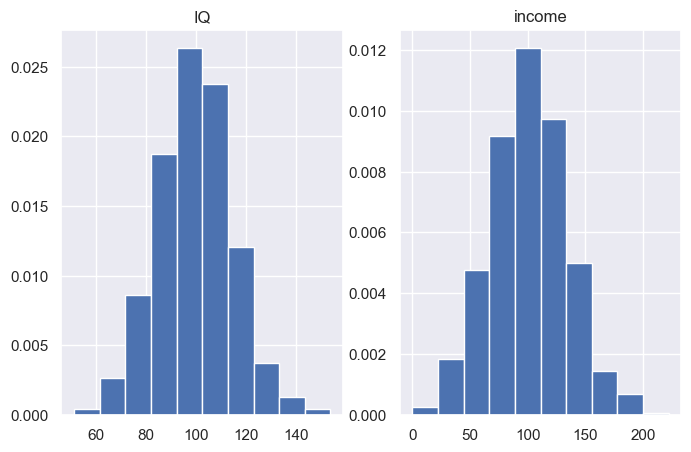

In [4]:
# Plotting histogram of IQ

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.hist(iq_values, density=True)
plt.title('IQ')

# Plotting histogram of Income
plt.subplot(1,2,2)
plt.hist(income_values, density=True)
plt.title('income')
plt.show()

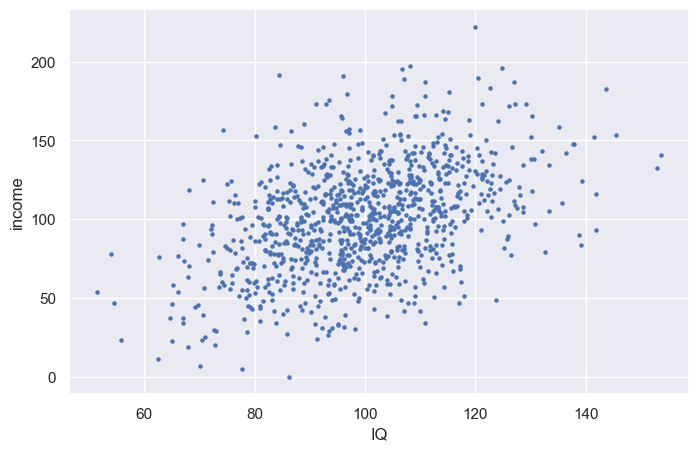

In [5]:
# PLotting a scatterplot between IQ and Income
plt.figure(figsize=(8,5))
plt.scatter(iq_values, income_values, s = 5)
plt.xlabel('IQ')
plt.ylabel('income')
plt.show()

In [6]:
print(f'Mean of IQ is {round(np.mean(iq_values),1)} and mean of Income is {round(np.mean(income_values),1)}')
print(f'Std of IQ is {round(np.std(iq_values),1)} and std of Income is {round(np.std(income_values),1)}')

Mean of IQ is 99.5 and mean of Income is 100.6
Std of IQ is 15.0 and std of Income is 33.3


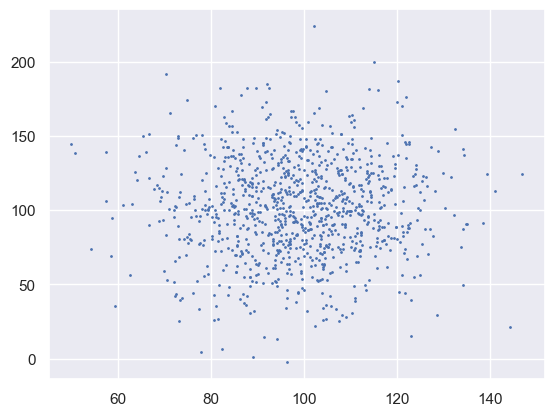

In [7]:
# Even if they were normal distributions but completely independent of each other,

x_axis = np.random.normal(np.mean(iq_values),np.std(iq_values),1000)
y_axis = np.random.normal(np.mean(income_values),np.std(income_values),1000)

plt.scatter(x_axis, y_axis, s = 1)

I. Minimize sum of squared deviations to compute optimal beta

$ min \sum \limits_ {i=1}^n (Y_n - \beta X_n)^2$

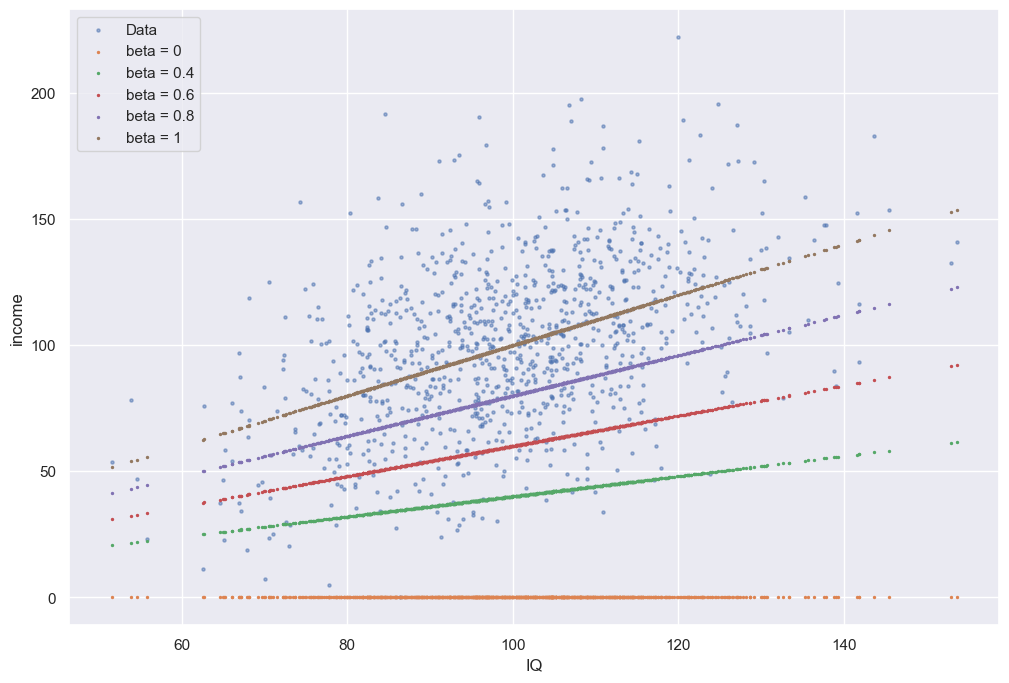

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(iq_values, income_values, s = 5, alpha=0.5, label = 'Data')

# Some example betas:


example_betas = [0,0.4,0.6,0.8,1]
for beta in example_betas:
    y = beta*iq_values
    plt.scatter(iq_values, y, s = 2, label = f'beta = {beta}')
    
plt.xlabel('IQ')
plt.ylabel('income')
plt.legend()
plt.show()


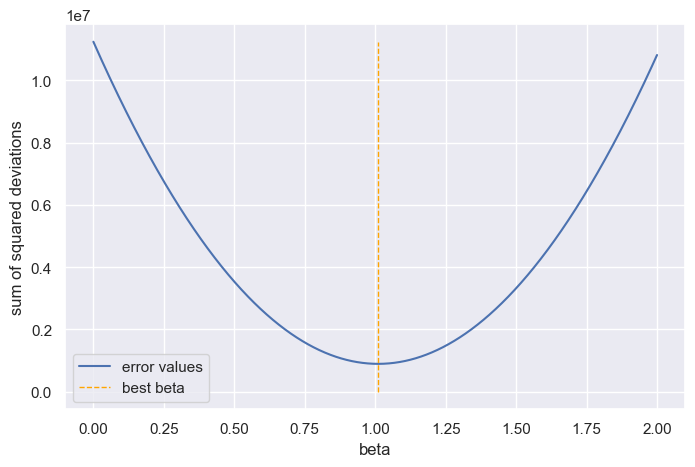

In [9]:
# creating the x axis of beta values
betas = np.linspace(0,2,1800) # (start, end, n): returns an array of n equidistant values between start and end

err = []
for i in range(len(betas)):
    beta = betas[i]
    
    # calculating our y_preds for a particular beta
    y_pred = beta*iq_values
    
    # calculating the difference between target and prediction (deviation)
    deviation = income_values- y_pred
    
    # deviation squared
    deviation_squared = (deviation)**2
    
    # error is the sum of squared deviations across all samples
    beta_error = np.sum(deviation_squared)
    
    # storing error value for plotting
    err.append(beta_error)

# Our best beta is the one which gives the least error
best_beta = betas[np.argmin(err)] # np.argmin gives the index of smallest value in the array    

plt.figure(figsize=(8,5))
plt.plot(betas, err, label = 'error values')
plt.vlines(best_beta, 0, np.max(err), color='orange', ls='--', lw=1, label = 'best beta')
plt.xlabel('beta')
plt.ylabel('sum of squared deviations')
plt.legend()
plt.show()

In [10]:
# The scale is in 1e7, so even tho it might be confused to see the line so close to 0,
# The minimum error is still:
min(err)

895629.5727653613

In [11]:
print('Optimal beta from "dropping marbles":', best_beta)

Optimal beta from "dropping marbles": 1.0105614230127848


II. Vector projections to compute the optimal beta

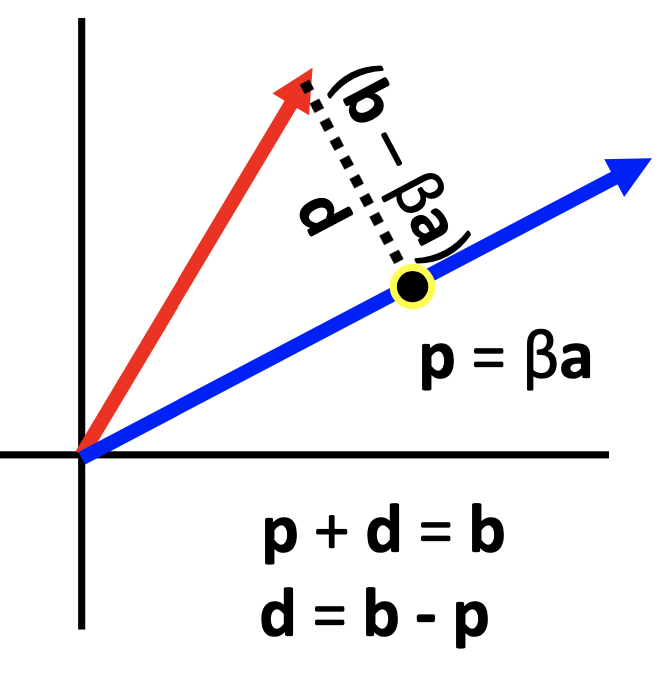

In [12]:
from IPython.display import Image
Image('vectorProjection.png', width=500)

We note that $(b-\beta a) \perp a$ to obtain $(b-\beta a)^T a = 0$. Solving for $\beta$, we get:

$\beta = \frac{a^Tb}{a^Ta}$

In [13]:
beta = np.dot(iq_values.T, income_values)/np.dot(iq_values.T, iq_values)
print('Optimal beta from vector projection:', beta)

Optimal beta from vector projection: 1.0105176272530692


#### Scikit learn

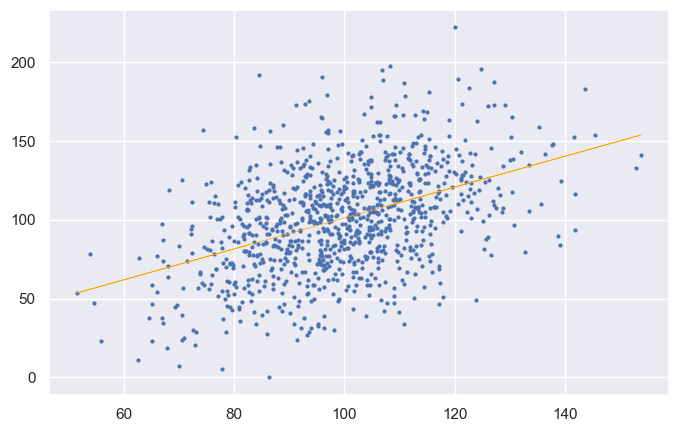

Optimal beta: 0.981
Offset: 2.992


In [14]:
# LinearRegression is a class in sklearn.linear_model that we imported earlier
reg = LinearRegression()

# we need to expand a dimension as Linear Regression takes input of shape (num_samples, num_features)
iq_exp = iq_values.reshape(-1,1) # going from shape (1000) -> (1000,1)

# fit our model on the data
reg.fit(iq_exp, income_values)

# Calculate y_hat
y_hat = float(reg.coef_)*iq_values + reg.intercept_

# Plotting our ground truth and our predictions
plt.figure(figsize=(8,5))
plt.plot(iq_values, income_values, 'o', ms=2)
plt.plot(iq_values, y_hat, color='orange', linewidth=0.5) # orange line for the fox
plt.show()

print('Optimal beta:', float(reg.coef_.round(3)))
print('Offset:', reg.intercept_.round(3))

## Multiple linear regression

Let's first take a look at the dataset

In [15]:
cursor.execute('SELECT * from determined_income')
determined_income = cursor.fetchall()
determined_income = np.asarray(determined_income)

print(f'shape of our matrix is: {determined_income.shape}\n\n\n')

iq_values = determined_income[:,0]
hours_worked_values = determined_income[:,1]
years_education_values = determined_income[:,2]
income_values = determined_income[:,3]

d = {'IQ': iq_values,
     'hours_worked': determined_income[:,1],
     'years_education': determined_income[:,2],
     'income': determined_income[:,3]
    }
for_viz = pd.DataFrame(d)

for_viz.head()

# # Seeing what the dataset looks like:
# print('Determined Income table:')
# print('-'*100)
# print('IQ\t\t\thours_worked\t\tyears_education\t\tincome')
# print('-'*100)
# for i in range(5):
#     for j in range(determined_income.shape[1]):
#         print(determined_income[i,j], end = '\t\t\t')
#     print()
# print('-'*100)


shape of our matrix is: (1500, 4)





,IQ,hours_worked,years_education,income
0,131.0,9.0,15.0,96.00
1,121.0,9.0,15.0,93.44
2,114.0,9.0,13.0,69.52
3,90.0,10.0,13.0,100.19
4,116.0,8.0,14.0,85.48


We can visualize multiple features simultaneously using a pairplot and the corresponding correlation matrix using a heatmap

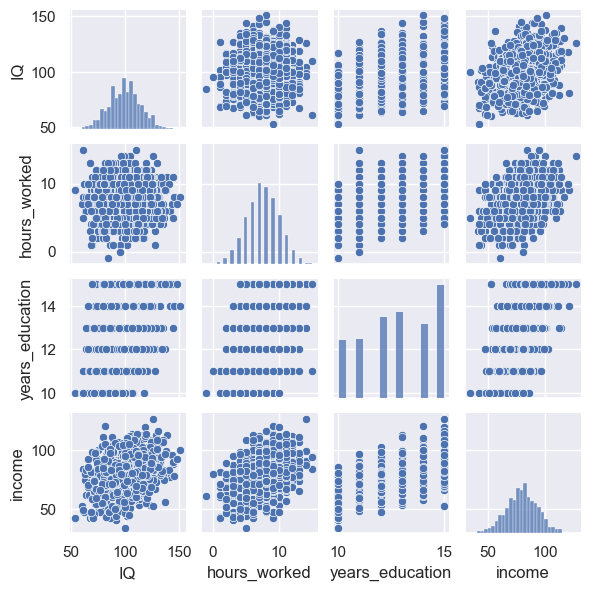

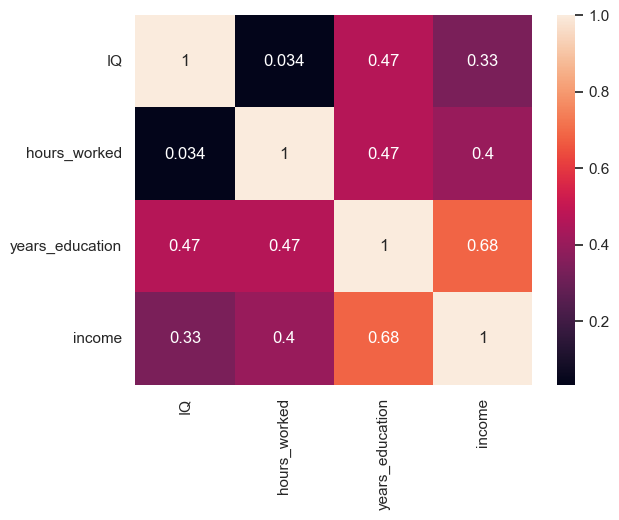

In [16]:
# Now we plot
sns.pairplot(for_viz, height=1.5)
plt.show()
sns.heatmap(for_viz.corr(), annot=True)
plt.show()

#### Let's build our model one feature at a time and note the $RMSE$ and $R^2$ each time.

In [17]:
# We will be building models to predict income based on 
# 1. IQ
# 2. IQ, hours_worked
# 3. IQ, hours_worked, years_education

# To retain common nomenclature and avoid confusion, we will define x before each model, but y will remain constant

y = income_values

Model 1: predicting income from IQ

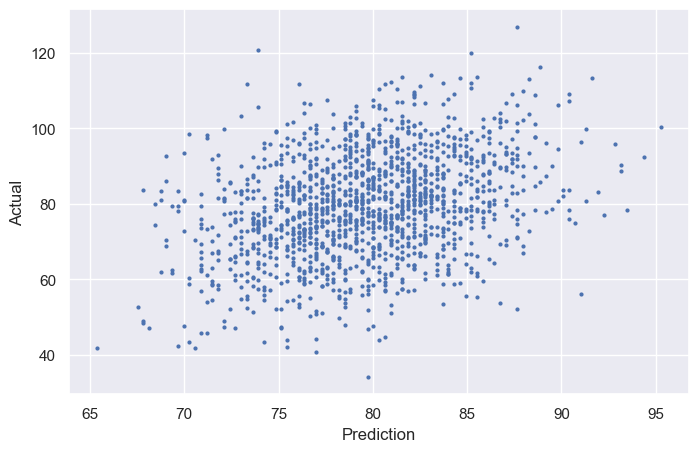

R^2: 0.111
RMSE: 498.849


In [18]:
iq_exp = iq_values.reshape(-1,1) # going from shape (1000) -> (1000,1)
x = iq_exp

reg = LinearRegression().fit(x.reshape(-1,1), y)
y_hat = reg.predict(x.reshape(-1,1))

plt.figure(figsize=(8,5))
plt.plot(y_hat, y, 'o', ms=2)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

r2 = r2_score(y,y_hat)
print('R^2:', r2.round(3))
rmse = np.sqrt(np.mean(np.sum((y-y_hat)**2)))
print('RMSE:', rmse.round(3))

Model 2: predicting income from IQ and hours worked

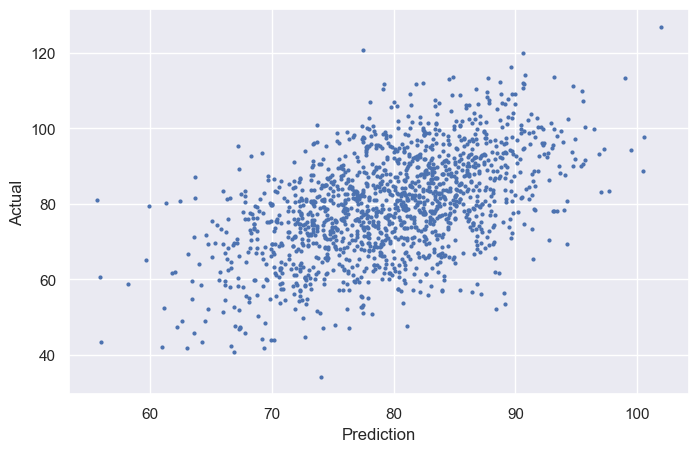

R^2: 0.265
RMSE: 453.623


In [19]:
hours_exp = hours_worked_values.reshape(-1,1) # going from shape (1000) -> (1000,1)

x = np.concatenate((iq_exp, hours_exp), axis=1) # going from shape (1000,1) and (1000,1) -> (1000,2)

reg = LinearRegression().fit(x,y)
y_hat = reg.predict(x)

plt.figure(figsize=(8,5))
plt.plot(y_hat, y, 'o', ms=2)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

r2 = r2_score(y,y_hat)
print('R^2:', r2.round(3))
rmse = np.sqrt(np.mean(np.sum((y-y_hat)**2)))
print('RMSE:', rmse.round(3))

Model 3: predicting income from IQ, hours worked and years education

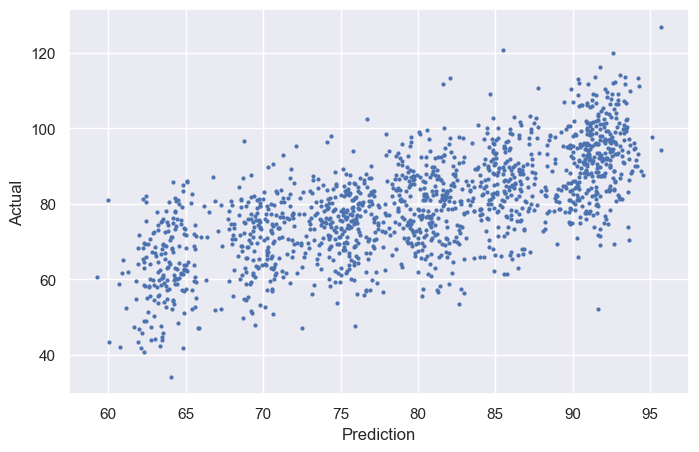

R^2: 0.478
RMSE: 382.401


In [20]:
years_exp = years_education_values.reshape(-1,1) # going from shape (1000) -> (1000,1)

x = np.concatenate((iq_exp, hours_exp, years_exp), axis=1) # going from shape (1000,1), (1000,1) and (1000,1) -> (1000,3)

reg = LinearRegression().fit(x,y)
y_hat = reg.predict(x)

plt.figure(figsize=(8,5))
plt.plot(y_hat, y, 'o', ms=2)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

r2 = r2_score(y,y_hat)
print('R^2:', r2.round(3))
rmse = np.sqrt(np.mean(np.sum((y-y_hat)**2)))
print('RMSE:', rmse.round(3))

#### Computing the optimal betas using matrix projection

We note that $X \perp e$, so $X^T e = 0$

Recall that $e = y - X \beta$; from this we obtain $X^T(y-X \beta)=0$

Solving for beta gives us $\beta = (X^T X)^{-1} X^T y$

In [21]:
beta = np.linalg.inv(x.T@x) @ (x.T@y)
print('Optimal betas:', beta)

Optimal betas: [0.07153278 0.70435587 5.22560744]


In general, we can use the Moore-Penrose pseudoinverse to solve a system of linear equations for which there is no solution

https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html

In [22]:
print('Optimal betas:', np.linalg.pinv(x)@y)

Optimal betas: [0.07153278 0.70435587 5.22560744]


Let's compare this to our scikit model

In [23]:
reg.coef_

array([0.04183517, 0.6817407 , 4.88445183])

## Correlation as dot product

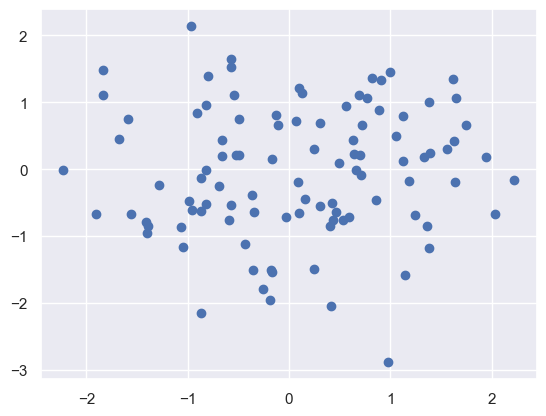

In [24]:
mu = 0 
sigma = 1
n = 100
scaleFactor = 1
x = np.random.normal(mu,sigma,n) 
y1 = np.random.normal(mu,sigma,n)
plt.plot(x, y1, 'o')
plt.show()

In [25]:
r = np.corrcoef(x,y1)[0,1] 
print('r:', r.round(3))

r: 0.054


In [26]:
y2 = x + (scaleFactor * np.random.normal(mu,sigma,n))
r = np.corrcoef(x,y2)[0,1] 
print('r:', r)

r: 0.5945859368164697


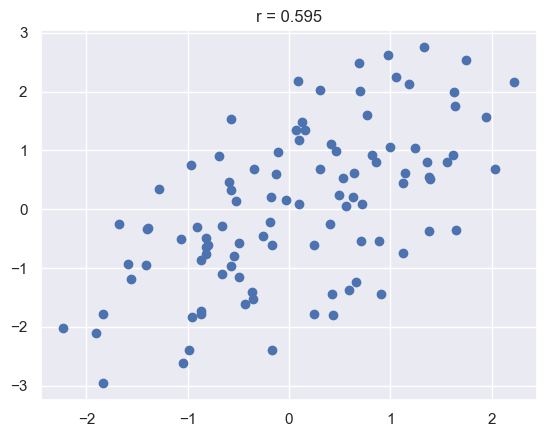

In [27]:
plt.plot(x, y2, 'o')
plt.title('r = {:.3f}'.format(r))
plt.show()

In [28]:
r_vec = np.dot(x/np.linalg.norm(x), y2/np.linalg.norm(y2)) 
print('Dot product:', r_vec)
print('Difference between corr and dot product:', abs(r-r_vec))

Dot product: 0.5945761177747597
Difference between corr and dot product: 9.819041709935306e-06


# Data Augmented Linear Regression

### Polynomial Regression

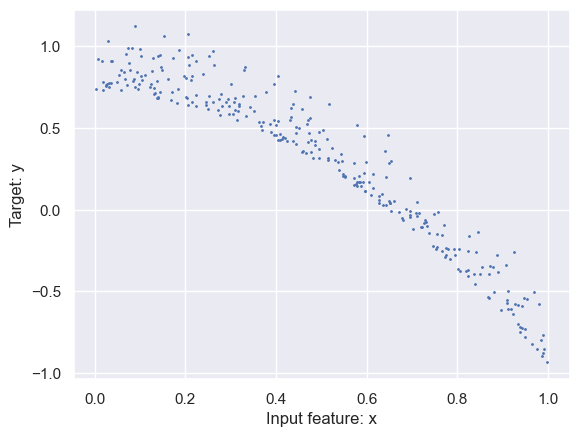

In [29]:
# Creating Synthetic dataset

np.random.seed(118)
num_points = 300
x = np.random.random((num_points))
# x = (np.random.random((num_points))-0.2)*3 # Now x is in range (-1,4)
a,b,c = (np.random.random(3)-0.5)*2
a = round(a,3)*4
b = round(b,3)*0.5
c = round(c,2)

noise_component = (np.random.random((num_points))*np.random.random((num_points)) -0.5)*0.5
y = a*x*x + b*x + c + noise_component





# You have 1 input feature (x) and 1 target feature (y)
plt.xlabel('Input feature: x')
plt.ylabel('Target: y')
plt.scatter(x,y, s = 1)
plt.show()

RMSE is,  0.15484738489542885


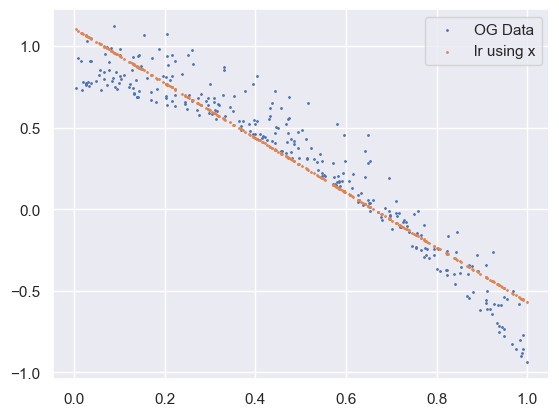

In [30]:
# Linear Regression with 'x' as input feature:

# Model
reg_single = LinearRegression().fit(x.reshape(-1,1), y)
y_hat_single = reg_single.predict(x.reshape(-1,1))

# RMSE Value
rmse_single = np.sqrt(np.mean((y-y_hat_single)**2))
print('RMSE is, ', rmse_single)

# Plotting
plt.scatter(x,y, s = 1, label = 'OG Data')
plt.scatter(x,y_hat_single, s = 1, label = 'lr using x')
plt.legend()
plt.show()

RMSE earlier was:  0.15484738489542885
RMSE now is:  0.10707004628097669


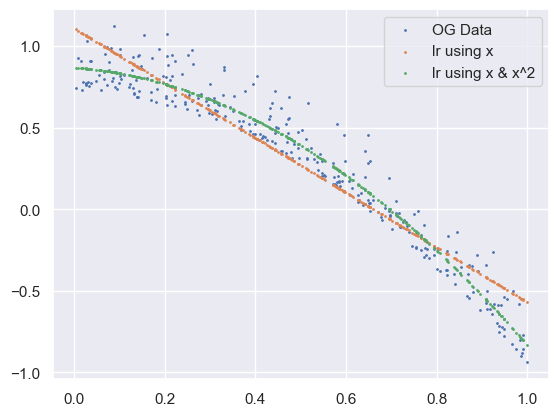

In [31]:
# Linear Regression with 'x', 'x^2' as input features:

x_sq = x*x
x_both = np.concatenate((x.reshape(-1,1),x_sq.reshape(-1,1)), axis = 1)
# print(x_both.shape)


# Model
reg_both = LinearRegression().fit(x_both, y)
y_hat_both = reg_both.predict(x_both.reshape(-1,2))

# RMSE Value
rmse_both = np.sqrt(np.mean((y-y_hat_both)**2))
print('RMSE earlier was: ', rmse_single)
print('RMSE now is: ', rmse_both)

# Plotting
plt.scatter(x,y, s = 1, label = 'OG Data')
plt.scatter(x,y_hat_single, s = 1, label = 'lr using x')
plt.scatter(x,y_hat_both, s = 1, label = 'lr using x & x^2')
plt.legend()
plt.show()

In [32]:
# Comparing coefficients from underlying function

print('Original coefficients: ', a,b,c)

a_single, b_single = reg_single.coef_[0], reg_single.intercept_
print('Linear Regression coefficients (ax+b)', a_single, b_single)

b_model, a_model = reg_both.coef_
c_model = reg.intercept_
print('Linear Regression coefficients (ax^2 + bx + c)', a_model, b_model, c_model)

Original coefficients:  -1.544 -0.128 0.98
Linear Regression coefficients (ax+b) -1.6777955122945074 1.1083051565571547
Linear Regression coefficients (ax^2 + bx + c) -1.495788946683088 -0.2060232236090008 7.613855969361865


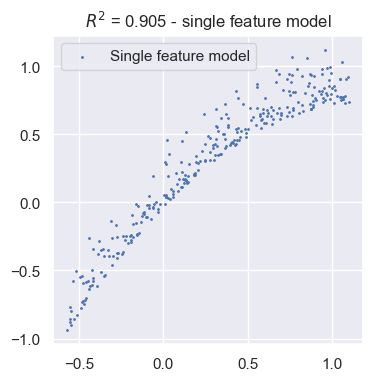

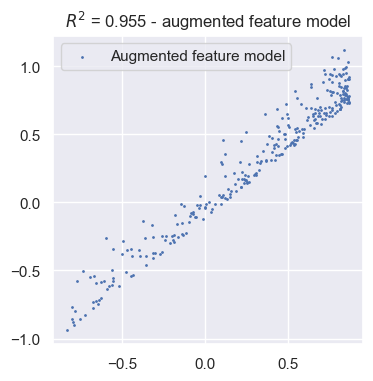

In [33]:
# Checking the R^2 values:

# For the single feature lr model
plt.figure(figsize=(4,4))
plt.scatter(y_hat_single, y, s = 1, label = 'Single feature model')
r2_single = r2_score(y,y_hat_single)
plt.title(f'$R^2$ = {round(r2_single,3)} - single feature model')
plt.legend()
plt.show()

# For the feature augmented lr model
plt.figure(figsize=(4,4))
plt.scatter(y_hat_both, y, s = 1, label = 'Augmented feature model')
r2_both = r2_score(y,y_hat_both)
plt.title(f'$R^2$ = {round(r2_both,3)} - augmented feature model')
plt.legend()
plt.show()


In [14]:
A = np.array([[3,2,2],[0,-1,1],[0,0,2]])
np.linalg.eig(A)

(array([ 3., -1.,  2.]),
 array([[ 1.        , -0.4472136 , -0.92998111],
        [ 0.        ,  0.89442719,  0.11624764],
        [ 0.        ,  0.        ,  0.34874292]]))